## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_10-18-05-23.csv', firstRow=414, lastRow=420)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_100523_S415-420.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=54s and ended at t=482s; mass=44.112750000000005g
This equals a volume of 44.201m; expected was 44.549mL; error is 0.781%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0015 g/s and for 2nd derivative = 0.00025000000000000006 g/s^2


<IPython.core.display.Javascript object>


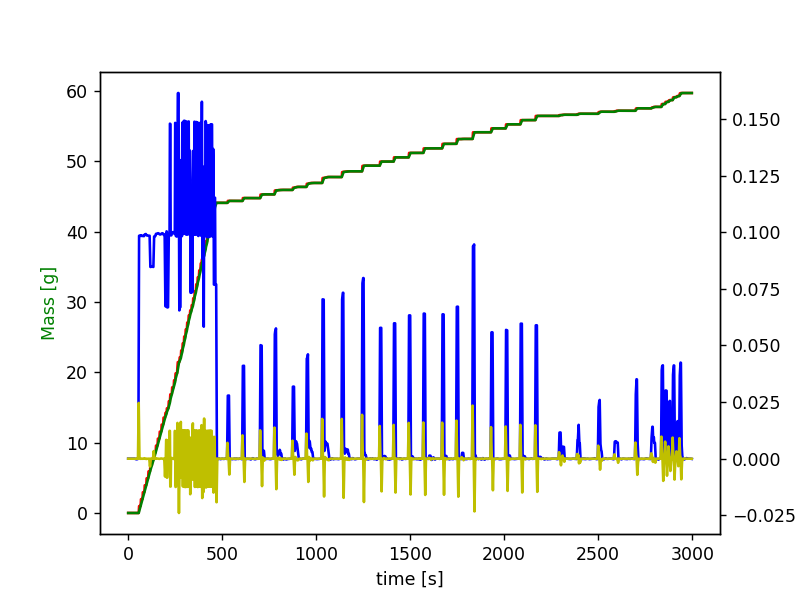

Addition of 0.277g Texapon SB 3 KC detected from 524s to 544s - expected volume = 0.513mL and actual volume = 0.25mL (resulting error is 51.326%)
Addition of 0.408g Texapon SB 3 KC detected from 604s to 624s - expected volume = 0.513mL and actual volume = 0.367mL (resulting error is 28.411%)
Addition of 0.534g Plantapon ACG 50 detected from 698s to 730s - expected volume = 0.512mL and actual volume = 0.473mL (resulting error is 7.595%)
Addition of 0.637g Plantapon ACG 50 detected from 774s to 822s - expected volume = 0.512mL and actual volume = 0.564mL (resulting error is 10.208%)
Addition of 0.432g Plantapon LC 7 detected from 870s to 912s - expected volume = 0.511mL and actual volume = 0.405mL (resulting error is 20.86%)
Addition of 0.565g Plantapon LC 7 detected from 944s to 988s - expected volume = 0.511mL and actual volume = 0.529mL (resulting error is 3.422%)
Addition of 0.846g Plantapon LC 7 detected from 1028s to 1074s - expected volume = 0.869mL and actual volume = 0.797mL (re

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0015625000000000003 g/s and for 2nd derivative = 0.00046875000000000015 g/s^2


<IPython.core.display.Javascript object>


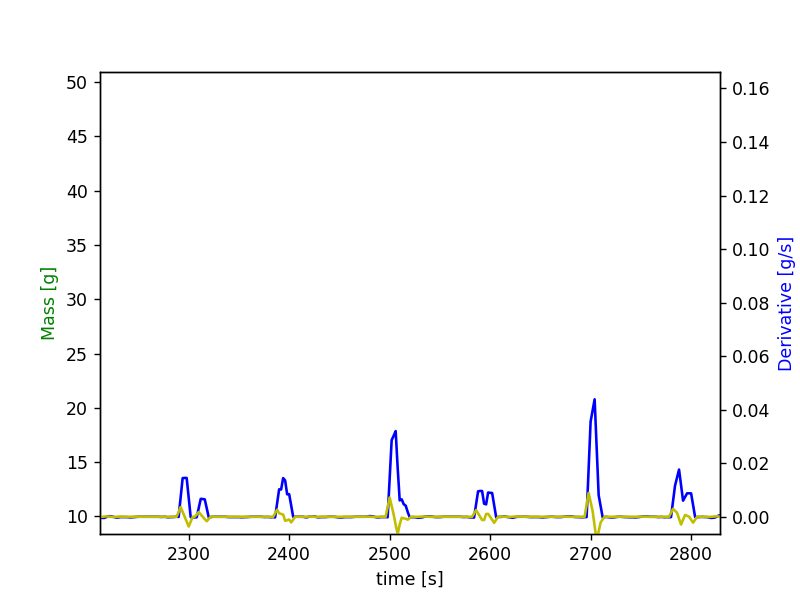

Addition of 0.165g Dehyquart CC6 detected from 2288s to 2324s - expected volume = 0.127mL and actual volume = 0.157mL (resulting error is 23.414%)
Addition of 0.148g Dehyquart CC6 detected from 2384s to 2408s - expected volume = 0.132mL and actual volume = 0.141mL (resulting error is 6.295%)
Addition of 0.291g Dehyquart CC6 detected from 2496s to 2524s - expected volume = 0.22mL and actual volume = 0.273mL (resulting error is 23.723%)
Addition of 0.146g Dehyquart CC6 detected from 2582s to 2610s - expected volume = 0.096mL and actual volume = 0.138mL (resulting error is 42.77%)
Addition of 0.348g Dehyquart CC6 detected from 2694s to 2716s - expected volume = 0.28mL and actual volume = 0.326mL (resulting error is 16.346%)
Addition of 0.209g Dehyquart CC6 detected from 2778s to 2808s - expected volume = 0.149mL and actual volume = 0.199mL (resulting error is 34.135%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


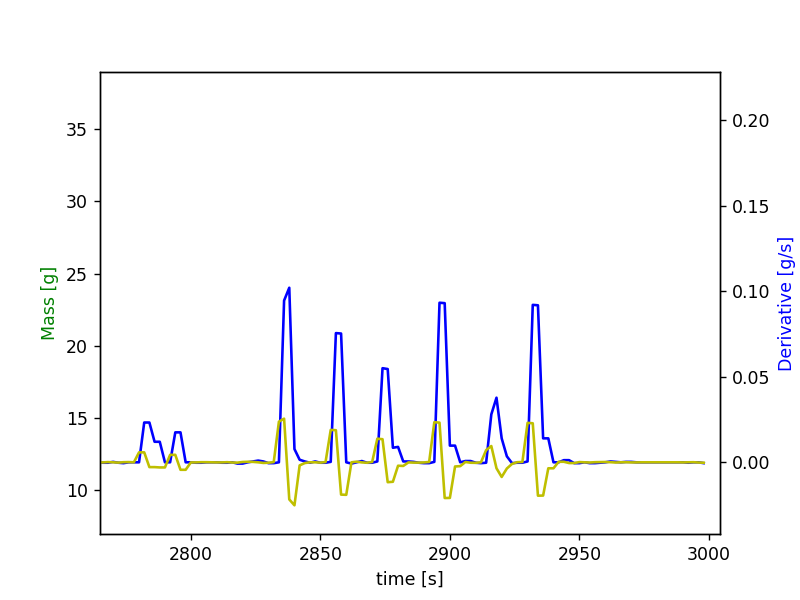

Addition of 0.41g Arlypon TT detected from 2832s to 2846s - expected volume = 0.471mL and actual volume = 0.429mL (resulting error is 8.889%)
Addition of 0.3g Arlypon TT detected from 2852s to 2864s - expected volume = 0.254mL and actual volume = 0.314mL (resulting error is 23.251%)
Addition of 0.256g Arlypon TT detected from 2870s to 2886s - expected volume = 0.226mL and actual volume = 0.265mL (resulting error is 17.123%)
Addition of 0.413g Arlypon TT detected from 2892s to 2908s - expected volume = 0.402mL and actual volume = 0.429mL (resulting error is 6.718%)
Addition of 0.163g Arlypon TT detected from 2912s to 2926s - expected volume = 0.104mL and actual volume = 0.168mL (resulting error is 61.386%)
Addition of 0.426g Arlypon TT detected from 2928s to 2944s - expected volume = 0.409mL and actual volume = 0.446mL (resulting error is 8.951%)


In [5]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [6]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_100523_S415-S420.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_33196\3486795694.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
414,415.0,0.000000,0.000000,0.000000,0.0,8.199064,8.17494,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.662278,0.0,0.0,0.0,4.121143
415,416.0,6.993473,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,13.709208,0.000000,0.0,1.508666,0.0,0.0,0.0,3.058177
416,417.0,0.000000,0.000000,9.935365,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,11.323548,0.0,2.895367,0.0,0.0,0.0,2.554296
417,418.0,0.000000,0.000000,8.378033,0.0,0.000000,0.00000,0.0,0.0,11.755586,0.0,0.000000,0.000000,0.0,1.441970,0.0,0.0,0.0,4.089502
418,419.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,12.687430,0.0,0.000000,11.761477,0.0,3.415865,0.0,0.0,0.0,1.600535
419,420.0,0.000000,11.386354,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,9.272620,0.000000,0.0,2.034493,0.0,0.0,0.0,4.141907
